In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header= 10, sep = '\t')
linksDf.index = linksDf.index.map(lambda x : unquote(x, 'utf-8'))
linksDf.columns = ['links']
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf



1) ETUDE DE L'IMPACT DES HUBS SUR LA VICTOIRE 


Création d'un dataframe, 'Hubs' contenant les pages wikipédia les plus visités à partir des données de 'paths_finished.tsv'

<AxesSubplot:xlabel='Elements'>

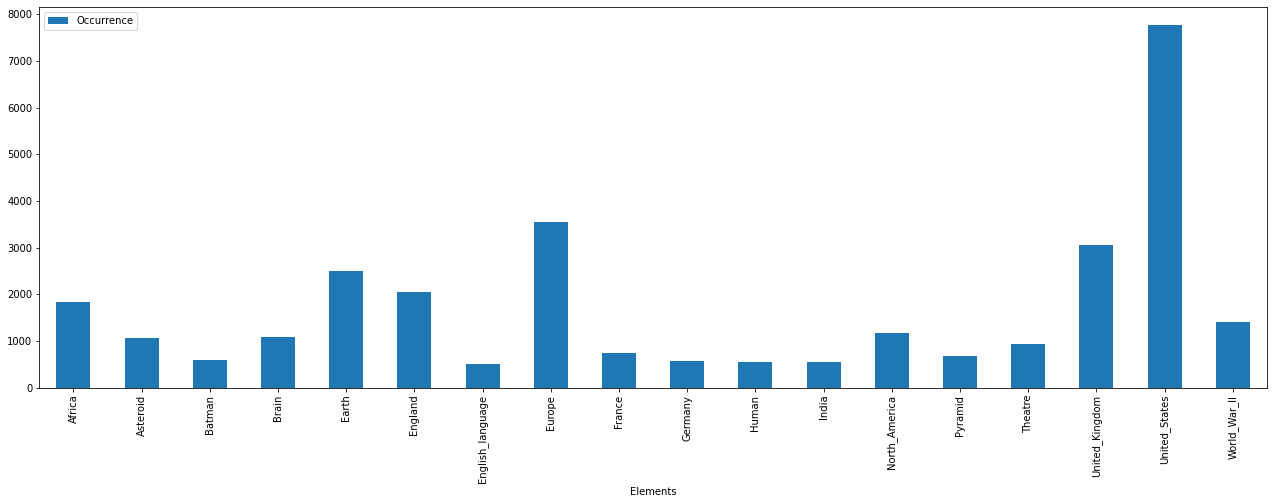

In [4]:
paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
paths = paths_finishedDf["path"].str.split(";", expand=True)

#Choisir un seuil adéquat !!!
seuil=500
hubs=pd.DataFrame(columns=['Elements', 'Occurrence'])
for i in range(0, paths.shape[1]):
    top_elements = paths.iloc[:, i].value_counts()
    elements_with_min_occurrences = top_elements[top_elements > seuil]
    
    # Créez un DataFrame temporaire pour les éléments et leurs occurrences
    temp_df = pd.DataFrame({'Elements': elements_with_min_occurrences.index, 'Occurrence': elements_with_min_occurrences.values})
    
    # Ajoutez le DataFrame temporaire à hubs
    hubs = pd.concat([hubs, temp_df], ignore_index=True)
hubs= hubs.groupby('Elements')['Occurrence'].sum().reset_index()

#Suppression '<' correspondant à des backclicks
valeur_a_supprimer = '<'
Hubs = hubs[hubs['Elements'] != valeur_a_supprimer]

# Réinitialisez l'indice si nécessaire
Hubs = Hubs.reset_index(drop=True)

plt.rcParams['figure.figsize']=(22,7)
Hubs.plot(x='Elements',  kind='bar')


Création d'un dataframe 'Hubs_unfinished', contenant les pages les plus visités dans le cas où les parties n'ont pas été terminé. 
Objectif : comparer les deux dataframe des hubs voir si certains Hubs dans 'hubs_unifinished' sont différents. Les pages manquantes (hubs uniquement de finished_paths) sont surement les hubs garantissant une victoire.

<AxesSubplot:xlabel='Elements'>

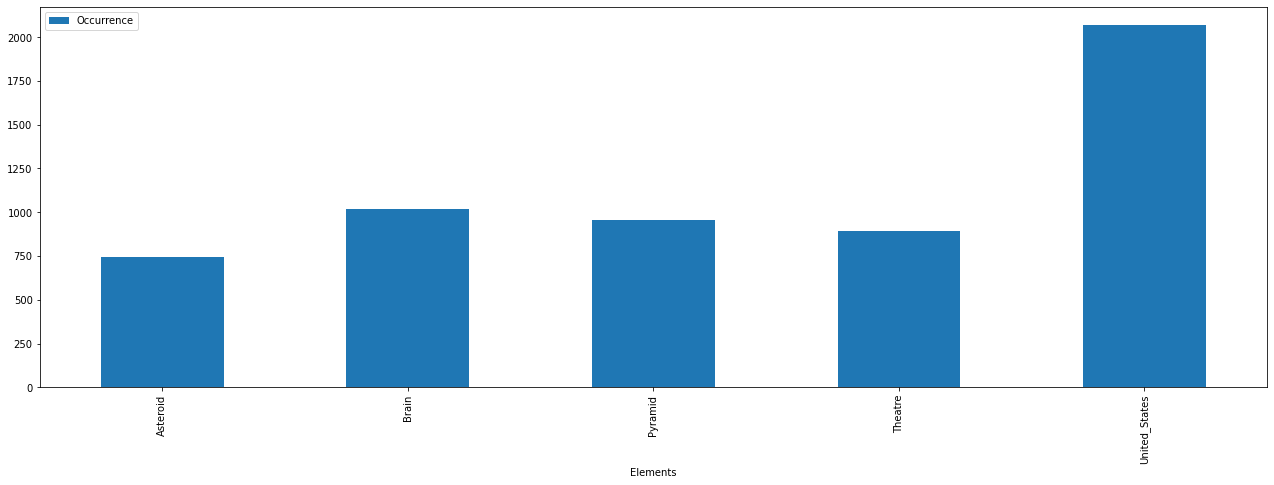

In [5]:
paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
paths_unfinished = paths_unfinishedDf["path"].str.split(";", expand=True)

seuil=500
hubs_unfinished=pd.DataFrame(columns=['Elements', 'Occurrence'])
for i in range(0, paths_unfinished.shape[1]):
    top_elements = paths_unfinished.iloc[:, i].value_counts()
    elements_with_min_occurrences = top_elements[top_elements > seuil]
    
    # Créez un DataFrame temporaire pour les éléments et leurs occurrences
    temp_df = pd.DataFrame({'Elements': elements_with_min_occurrences.index, 'Occurrence': elements_with_min_occurrences.values})
    
    # Ajoutez le DataFrame temporaire à hubs
    hubs_unfinished = pd.concat([hubs_unfinished, temp_df], ignore_index=True)
hubs_unfinished= hubs_unfinished.groupby('Elements')['Occurrence'].sum().reset_index()

#Suppression '<' correspondant à des backclicks
valeur_a_supprimer = '<'
Hubs_unfinished = hubs_unfinished[hubs_unfinished['Elements'] != valeur_a_supprimer]

# Réinitialisez l'indice si nécessaire
Hubs_unfinished = Hubs_unfinished.reset_index(drop=True)

plt.rcParams['figure.figsize']=(22,7)
Hubs_unfinished.plot(x='Elements',  kind='bar')

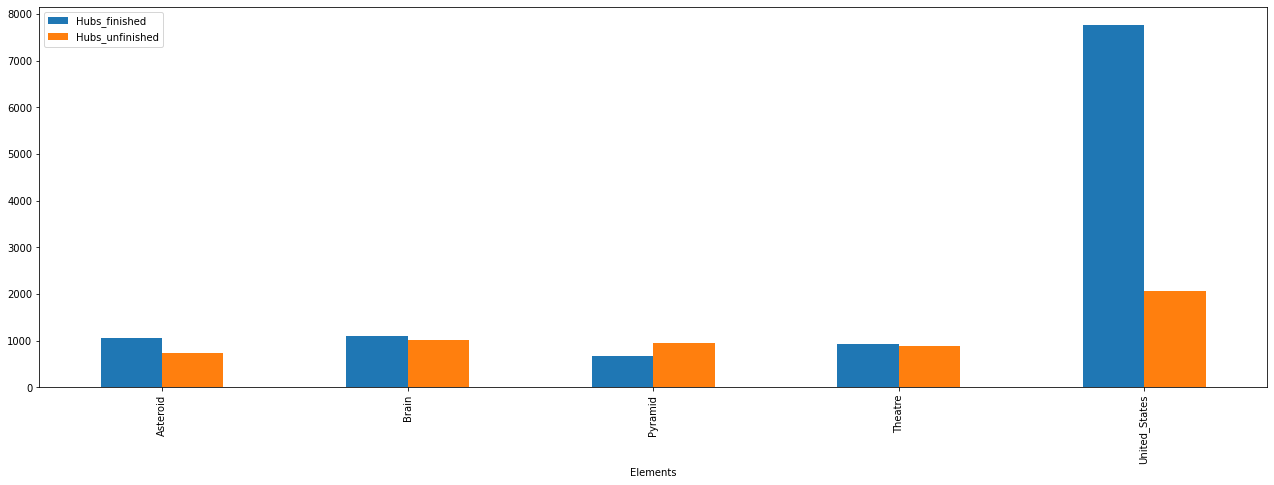

In [6]:
#dataframe intersection
intersection_df=pd.merge(Hubs, Hubs_unfinished, on=['Elements'])

#plot de l'intersection des hubs et de leur occurence
intersection_df = intersection_df.rename(columns={'Occurrence_x': 'Hubs_finished'})
intersection_df = intersection_df.rename(columns={'Occurrence_y': 'Hubs_unfinished'})
intersection_df.plot(x='Elements', y=['Hubs_finished', 'Hubs_unfinished'], kind='bar')

#dataframe difference
difference_df = Hubs[Hubs['Elements'] != 'Asteroid']
difference_df = difference_df[difference_df['Elements'] != 'Brain']
difference_df = difference_df[difference_df['Elements'] != 'Pyramid']
difference_df = difference_df[difference_df['Elements'] != 'Theatre']
difference_df = difference_df[difference_df['Elements'] != 'United_States']


Peut-être il y a des mauvais hubs, par exemple pyramide mène plus de fois à des parties pas terminé. Arrivé sur les hubs comme 'pyramid', 'brain', 'theatre' augmente peut être les probabilités de perdre.


Créer des nouveaux dataframe pour effectuer le chi2-test : 

- victory_paths_with_hubs : contenant toutes les victoires contenant au moins un passage dans un hubs 
- victory_paths_without_hubs : contenant toutes les victoires sans un passage par un hubs
- unfinished_paths_with_hubs 
- unfinishes_paths_without_hubs 

C'est dataframe sont créée en utilisant uniquement les hubs des 'finished_paths'

In [7]:
#VICTORY PATH WITH HUBS
liste_index=[]
for index, row in tqdm(paths.iterrows()):
    for col in paths.columns:
        cell_value = row[col]
        if cell_value in Hubs['Elements'].tolist():
            liste_index.append(index)

#garder que les valeurs unique de la liste 
liste_index[:] = list(set(liste_index)) 

#garder que les lignes de code du dataframe victoire qui contiennent un hubs
victory_path_with_hubs = paths_finishedDf.loc[liste_index]

51317it [02:12, 388.73it/s]


In [9]:
# VICTORY PATH WITHOUT HUBS 
victory_path_without_hubs = paths_finishedDf.merge(victory_path_with_hubs ,indicator = True, how='left').loc[lambda x : x['_merge']!='both']

In [10]:
#UNFINISHED PATH WITH HUBS (hubs des finished path)
liste_index1=[]
for index, row in tqdm(paths_unfinished.iterrows()):
    for col in paths_unfinished.columns:
        cell_value = row[col]
        if cell_value in Hubs['Elements'].tolist():
            liste_index1.append(index)

#garder que les valeurs unique de la liste 
liste_index1[:] = list(set(liste_index1)) 

#garder que les lignes de code du dataframe des défaites qui contiennent un hubs
unfinished_path_with_hubs = paths_unfinishedDf.loc[liste_index1]

24874it [00:35, 703.14it/s]


Chi2 test : 
- H0 : Le passage par un hub n'a pas d'effet significatif sur la victoire.
- H1 : Le passage par un hub a un effet significatif sur la victoire. 

Création d'une Contingency table : "displays frequencies for combinations of two categorical variables"  

|  | Victoire | Défaite |
|-----------|-----------|-----------|
| Hubs  | 29216 | 11961  |
| No Hubs  | 22101  | 12913  |

In [26]:
from scipy.stats import chi2_contingency
import numpy as np


contingency_table = np.array([[29216, 11961], [22101, 12913]])

res =chi2_contingency(contingency_table)

print(f"pvalue = {res.pvalue}")

pvalue = 9.900550897469671e-117


Using a significance level of 5%, we would reject the null hypothesis in favor of the alternative hypothesis: "Le passage par un hub a un effet significatif sur la victoire ".  
Indeed the p-value is way smaller than 0.05. 

2- Y-A-T-IL DES MAUVAIS HUBS ? 

Voir si certains hubs garantissent plus une défaite qu'une victoire. Pour cela on s'intéresse au Hubs de unfinished paths. On retire le hubs Etats-Unis qui selon le graph est plus impliqué dans des victoires que dans des défaites pour éviter de biaiser le test. 


In [49]:
#Retirer Etats-Unis 
hubs_unfinished = Hubs_unfinished[Hubs_unfinished['Elements'] != 'United_States']

victory_bad_hubs=[]
for index, row in tqdm(paths.iterrows()):
    for col in paths.columns:
        cell_value = row[col]
        if cell_value in hubs_unfinished['Elements'].tolist():
            victory_bad_hubs.append(index)
victory_bad_hubs[:] = list(set(victory_bad_hubs))


defeat_bad_hubs=[]
for index, row in tqdm(paths_unfinished.iterrows()):
    for col in paths_unfinished.columns:
        cell_value = row[col]
        if cell_value in hubs_unfinished['Elements'].tolist():
            defeat_bad_hubs.append(index)
defeat_bad_hubs[:] = list(set(defeat_bad_hubs))

victory_bad_hubs = len(victory_bad_hubs)
defeat_bad_hubs = len(defeat_bad_hubs)

51317it [02:13, 385.33it/s]
24874it [00:37, 667.06it/s]


In [50]:
victory_no_bad_hubs = paths_finishedDf.shape[0] - victory_bad_hubs
defeat_no_bad_hubs = paths_unfinishedDf.shape[0] - defeat_bad_hubs


print(f"Victory with bad hubs : {victory_bad_hubs}")
print(f"Victory with no bad hubs : {victory_no_bad_hubs}")
print(f"Defeat with bad hubs : {defeat_bad_hubs}")
print(f"Defeat with no bad hubs : {defeat_no_bad_hubs}")

Victory with bad hubs : 4266
Victory with no bad hubs : 47051
Defeat with bad hubs : 3738
Defeat with no bad hubs : 21136


Chi2 test :  
- H0 : Le passage par un 'bad hub' n'a pas d'effet significatif sur la victoire.
- H1 : Le passage par un 'bad hub' a un effet significatif sur la victoire. 

Contingency table : 

|  | Victoire | Défaite |
|-----------|-----------|-----------|
| 'Bad Hubs' | 4266 | 3738  |
| No 'Bad Hubs'  | 47051  | 21136  |

In [51]:
contingency_table2 = np.array([[victory_bad_hubs, defeat_bad_hubs], [victory_no_bad_hubs, defeat_no_bad_hubs]])

res =chi2_contingency(contingency_table2)

print(f"pvalue = {res.pvalue}")

pvalue = 1.3754646469481335e-176


On peut rejeter l'hypothèse nulle H0 en faveur de l'hypothèse alternative à 95% : "Le passage par un 'bad hub' a un effet significatif sur la victoire.   
Donc il est possible de conclure que certains hubs semble être des faux amis, il s'agit des pages Asteroid, Brain, Pyramid et Theatre.

Etudier le lien entre passage par un hubs et la difficulté de la partie  : 
(résultat pas hyper intéressant)

In [59]:
difficulty_hubs=victory_path_with_hubs['rating'].mean(skipna=True)
mean_time_hubs = victory_path_with_hubs['durationInSec'].mean()
print(difficulty_hubs)
print(mean_time_hubs)

difficulty=victory_path_without_hubs['rating'].mean(skipna=True)
mean_time = victory_path_without_hubs['durationInSec'].mean()
print(difficulty)
print(mean_time)

2.340553932156016
171.45492196056955
2.1824594403950153
140.85448622234287


Etudier le lien entre le passage par un hub et la longueur du pathways

In [88]:
import statistics
path_length_hubs=[]
for index, row in victory_path_with_hubs.iterrows():
    cellule= victory_path_with_hubs['path'][index]
    nb = cellule.count(';') + 1
    path_length_hubs.append(nb)

mean_paths_hubs=statistics.mean(path_length_hubs)
print(mean_paths_hubs)

7.20434008762322


In [89]:
#longueur des 
path_length=[]
for index, row in victory_path_without_hubs.iterrows():
    cellule= victory_path_without_hubs['path'][index]
    nb = cellule.count(';') + 1
    path_length.append(nb)

mean_paths=statistics.mean(path_length)
print(mean_paths)

6.166553549613139


(0.0, 120.0)

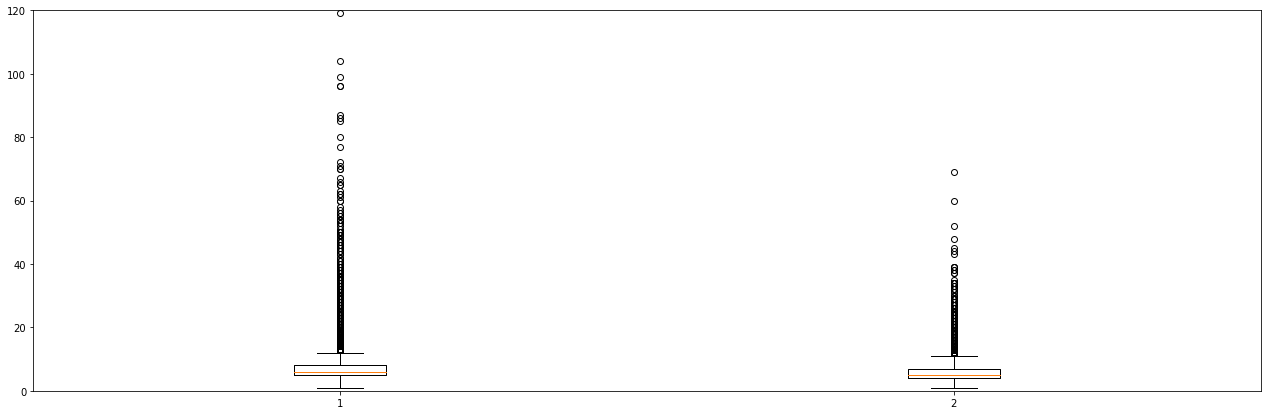

In [87]:
x1=np.linspace(0, 29216, 29216, dtype=int)
x2=np.linspace(0, 22101, 22101, dtype=int)
plt.boxplot([path_length_hubs, path_length]) 

plt.ylim(0,120)

Le passage par un hub ne permet pas de finir une partie plus rapidement, ne réduit pas le path, et ne baisse pas la difficulté ressenti par un joueur.